In [1]:
from __future__ import absolute_import, division, print_function

In [9]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
corpus_filename = '../data/extracted_emoji_sequences.txt'


In [4]:
corpus = open(corpus_filename).read().splitlines()


In [8]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

In [9]:
def onlyEmojiSequences(tokens):
    threshold_emojis = [x for x in tokens if len(x) > 1]
    return threshold_emojis

In [10]:
tokenized_corpus = tokenize_corpus(corpus)
emojiSequences = onlyEmojiSequences(tokenized_corpus)

In [11]:
token_count = sum([len(sentence) for sentence in emojiSequences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 610,256 tokens


# training the model

In [12]:
# Dimensionality of the resulting word vectors.
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

# think of how to set those variables so that variables from different tweets are not learned from together!


In [13]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [14]:
thrones2vec.build_vocab(emojiSequences)

2019-01-03 22:28:46,468 : INFO : collecting all words and their counts
2019-01-03 22:28:46,469 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-03 22:28:46,474 : INFO : PROGRESS: at sentence #10000, processed 26070 words, keeping 817 word types
2019-01-03 22:28:46,481 : INFO : PROGRESS: at sentence #20000, processed 52738 words, keeping 934 word types
2019-01-03 22:28:46,487 : INFO : PROGRESS: at sentence #30000, processed 80617 words, keeping 992 word types
2019-01-03 22:28:46,492 : INFO : PROGRESS: at sentence #40000, processed 106997 words, keeping 1018 word types
2019-01-03 22:28:46,498 : INFO : PROGRESS: at sentence #50000, processed 134684 words, keeping 1037 word types
2019-01-03 22:28:46,504 : INFO : PROGRESS: at sentence #60000, processed 161638 words, keeping 1052 word types
2019-01-03 22:28:46,511 : INFO : PROGRESS: at sentence #70000, processed 189166 words, keeping 1064 word types
2019-01-03 22:28:46,517 : INFO : PROGRESS: at sentence #800

In [15]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))


Word2Vec vocabulary length: 1082


In [16]:
thrones2vec.train(emojiSequences, total_examples=thrones2vec.corpus_count, epochs = 1000)


2019-01-03 22:28:46,649 : INFO : training model with 8 workers on 1082 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-01-03 22:28:46,966 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-01-03 22:28:46,967 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-03 22:28:46,968 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-01-03 22:28:46,970 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-01-03 22:28:46,971 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-03 22:28:46,976 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-03 22:28:46,977 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-03 22:28:46,978 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-03 22:28:46,978 : INFO : EPOCH - 1 : training on 610256 raw words (388701 effective words) took 0.3s, 1218243 effec

(388914859, 610256000)

In [12]:
if not os.path.exists("trainfed"):
    os.makedirs("trainfed")

In [18]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2019-01-03 22:34:11,229 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2019-01-03 22:34:11,230 : INFO : not storing attribute vectors_norm
2019-01-03 22:34:11,231 : INFO : not storing attribute cum_table
2019-01-03 22:34:11,254 : INFO : saved trained/thrones2vec.w2v


# explore the trained model

In [11]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

NameError: name 'w2v' is not defined

In [20]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [21]:
all_word_vectors_matrix = thrones2vec.wv.vectors

In [22]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [23]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [24]:
sns.set_context("poster")

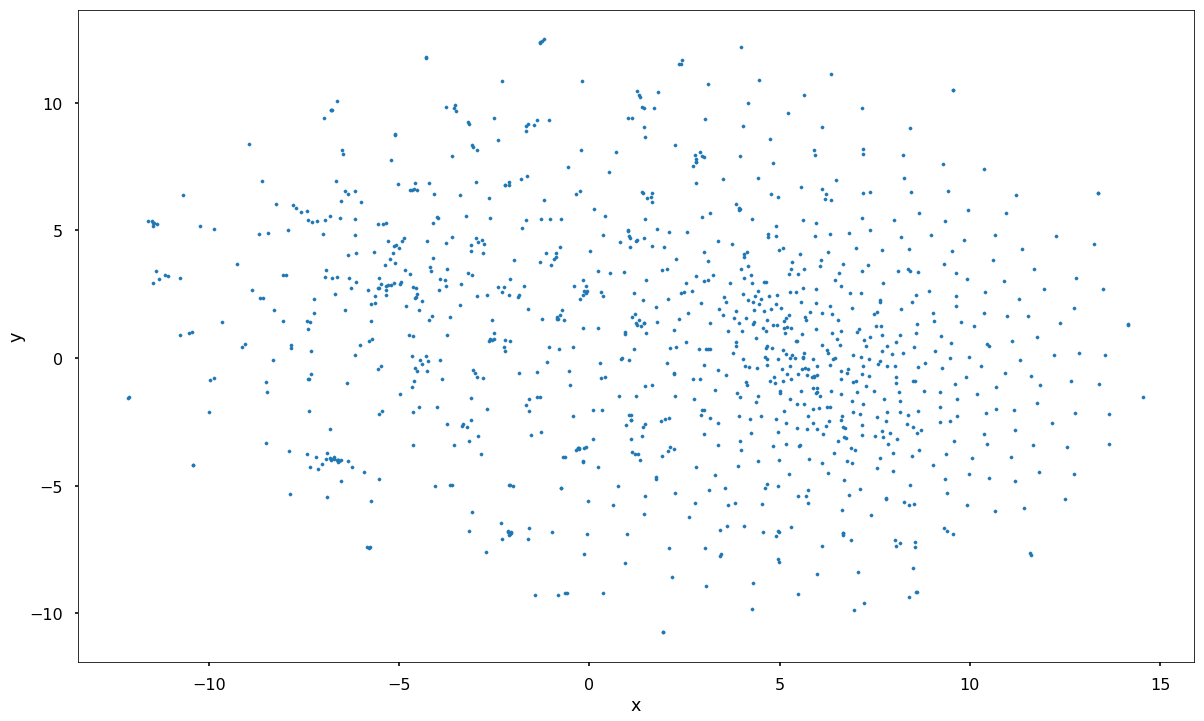

In [25]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [27]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

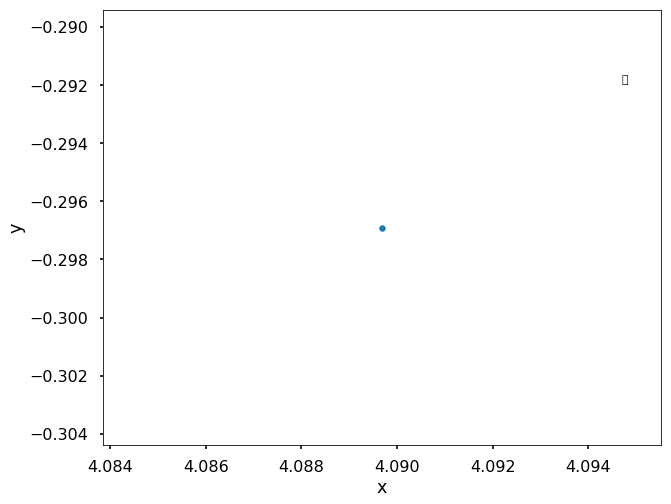

In [28]:
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))


In [5]:
thrones2vec.most_similar("🍆")

NameError: name 'thrones2vec' is not defined